### Packages

In [4]:
###Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

ModuleNotFoundError: No module named 'skopt'

In [5]:
!pip install skopt

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


## Data Import

In [6]:
df = pd.read_csv("DataTrain-2.csv")

#### Check for null values and infinite values

In [7]:
# Checking which columns have any null values
columns_with_nulls = df.isnull().any()

# Filtering to show only columns with null values
columns_with_nulls_true = columns_with_nulls[columns_with_nulls].index.tolist()

print("Columns with null values:", columns_with_nulls_true)

# Check for columns with infinite values (positive or negative)
infinite_columns = df.isin([np.inf, -np.inf]).any()

# Filter and print column names that have infinite values
columns_with_infinity = infinite_columns[infinite_columns].index.tolist()
print("Columns with infinite values:", columns_with_infinity)

Columns with null values: []
Columns with infinite values: []


#### Create a new column RUL 

In [8]:
# Creating a new column with the max 'cycle' per 'engine_id'
df['max_cycle_per_engine'] = df.groupby('engine_id')['cycle'].transform('max')
# Creating the 'cycles_left' column
df['RUL'] = df['max_cycle_per_engine'] - df['cycle']
df.drop(['max_cycle_per_engine'], axis=1, inplace=True)

### Remove features with zero variance

In [9]:
# Calculating variance for each column
variances = df.var()

# Identifying columns with zero variance
zero_variance_columns = variances[variances == 0].index.tolist()

print("Columns with zero variance:", zero_variance_columns)

# Filtering out columns with zero variance
df = df.loc[:, variances > 0]

Columns with zero variance: ['set1', 'sensor_val7', 'sensor_val11', 'sensor_val14', 'sensor_val16']


#### Remove the columns with one unique value

In [10]:
# Checking the number of unique values per column
unique_counts = df.nunique()

# Identifying columns with only one unique value
columns_to_remove = unique_counts[unique_counts == 1].index.tolist()

# Removing these columns from the DataFrame
df.drop(columns=columns_to_remove, inplace=True)

# Printing the names of the columns that were removed
print("Columns removed:", columns_to_remove)

Columns removed: ['sensor_val8', 'sensor_val20']


              engine_id     cycle      set2      set3  sensor_val1  \
engine_id      1.000000  0.078753 -0.017895 -0.006197    -0.052053   
cycle          0.078753  1.000000 -0.004527  0.016132     0.443999   
set2          -0.017895 -0.004527  1.000000  0.011660    -0.004279   
set3          -0.006197  0.016132  0.011660  1.000000    -0.005425   
sensor_val1   -0.052053  0.443999 -0.004279 -0.005425     1.000000   
sensor_val2   -0.031882 -0.611354 -0.001491 -0.010923    -0.210238   
sensor_val3   -0.059473  0.370324 -0.004469 -0.006310     0.963157   
sensor_val4    0.012621  0.543947 -0.005651  0.009068     0.322964   
sensor_val5   -0.032073 -0.595914 -0.009437 -0.016678    -0.217835   
sensor_val6   -0.020589 -0.583597 -0.005713 -0.010554    -0.285280   
sensor_val9    0.044230  0.477523  0.002318  0.018156    -0.034763   
sensor_val10   0.026116  0.624577  0.009544  0.014673     0.297429   
sensor_val12   0.013513  0.566995  0.002599  0.012280     0.337110   
sensor_val13   0.039

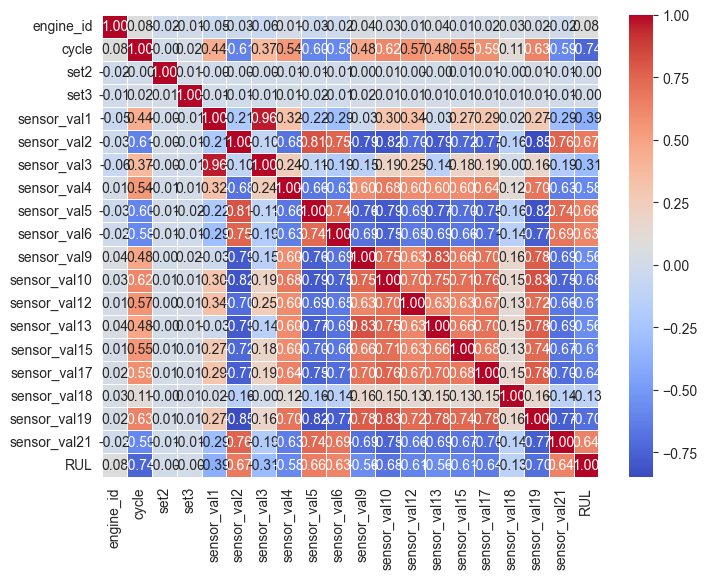

In [11]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualizing the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [12]:
rul_correlations = correlation_matrix['RUL']

# Display the correlations of 'RUL' with other features
print(rul_correlations)

engine_id       0.078753
cycle          -0.736241
set2           -0.003198
set3           -0.001948
sensor_val1    -0.390102
sensor_val2     0.671983
sensor_val3    -0.306769
sensor_val4    -0.584520
sensor_val5     0.657223
sensor_val6     0.629428
sensor_val9    -0.562569
sensor_val10   -0.678948
sensor_val12   -0.606154
sensor_val13   -0.563968
sensor_val15   -0.606484
sensor_val17   -0.642667
sensor_val18   -0.128348
sensor_val19   -0.696228
sensor_val21    0.635662
RUL             1.000000
Name: RUL, dtype: float64


In [13]:
df.columns

Index(['engine_id', 'cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21', 'RUL'],
      dtype='object')

In [14]:
df

,engine_id,cycle,set2,set3,sensor_val1,sensor_val2,sensor_val3,sensor_val4,sensor_val5,sensor_val6,sensor_val9,sensor_val10,sensor_val12,sensor_val13,sensor_val15,sensor_val17,sensor_val18,sensor_val19,sensor_val21,RUL
0,1,1,-0.0007,-0.0004,9046.19,521.66,8138.62,1589.70,554.36,39.06,2388.02,1400.60,392,2388.06,641.82,8.4195,21.61,47.47,23.4190,191
1,1,2,0.0019,-0.0003,9044.07,522.28,8131.49,1591.82,553.75,39.00,2388.07,1403.14,392,2388.04,642.15,8.4318,21.61,47.49,23.4236,190
2,1,3,-0.0043,0.0003,9052.94,522.42,8133.23,1587.99,554.26,38.95,2388.03,1404.20,390,2388.08,642.35,8.4178,21.61,47.27,23.3442,189
3,1,4,0.0007,0.0000,9049.48,522.86,8133.83,1582.79,554.45,38.88,2388.08,1401.87,392,2388.11,642.35,8.3682,21.61,47.13,23.3739,188
4,1,5,-0.0019,-0.0002,9055.15,522.19,8133.80,1582.85,554.00,38.90,2388.04,1406.22,393,2388.06,642.37,8.4294,21.61,47.28,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,9065.52,519.49,8137.60,1597.98,551.43,38.49,2388.26,1428.63,397,2388.19,643.49,8.4956,21.61,48.07,22.9735,4
20627,100,197,-0.0016,-0.0005,9065.11,519.68,8136.50,1604.50,550.86,38.30,2388.22,1433.58,395,2388.23,643.54,8.5139,21.61,48.04,23.1594,3
20628,100,198,0.0004,0.0000,9065.90,520.01,8141.05,1602.46,550.94,38.44,2388.24,1428.18,398,2388.24,643.42,8.5646,21.61,48.09,22.9333,2
20629,100,199,-0.0011,0.0003,9073.72,519.67,8139.29,1605.26,550.68,38.29,2388.23,1426.53,395,2388.25,643.23,8.5389,21.61,48.39,23.0640,1


In [11]:
# Defining the dependent variable and independent variables
X = df[['cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21']]
y = df['RUL']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Setting up the OLS model
model = sm.OLS(y, X)

# Fitting the model
results = model.fit()

# Printing the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2180.
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        11:01:17   Log-Likelihood:            -1.0560e+05
No. Observations:               20631   AIC:                         2.112e+05
Df Residuals:                   20612   BIC:                         2.114e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.259e+05   2.59e+04      4.853   

eventhough set 2 had a higher correlation with RUL than set 3, controlling for other variables revealed that set 2 is not significant

remove set 2 as a feature

In [12]:
df.drop(["engine_id","set2"], axis=1, inplace=True)

In [13]:
# Define the dependent variable and independent variables
X = df.drop('RUL', axis=1)
y = df['RUL']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Applying 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))

# Output the results of cross-validation
print("CV Scores:", cv_scores)
print("CV Average Score:", np.mean(cv_scores))

CV Scores: [24.90042411 25.8700515  25.47068767 25.46362617 25.63502727]
CV Average Score: 25.467963346093466


In [15]:
# Random Forest model setup
rf = RandomForestRegressor(random_state=42)

# Setting up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", grid_search.best_params_)
print("Best score (neg_mean_absolute_error):", grid_search.best_score_)

# Optionally, check the performance on the test set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [17]:
# Random Forest model setup
rf = RandomForestRegressor(random_state=42)

# Define parameter space for Bayesian Optimization
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

# Setting up Bayesian Search
opt = BayesSearchCV(estimator=rf, search_spaces=search_spaces, n_iter=32, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2, random_state=42)

# Fitting Bayesian Search
opt.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", opt.best_params_)
print("Best score (neg_mean_absolute_error):", opt.best_score_)

# Optionally, check the performance on the test set
best_rf = opt.best_estimator_
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)

NameError: name 'Integer' is not defined

In [16]:
# Specify the file path to save the model
model_file_path = 'best_random_forest_model.pkl'

# Save the model to disk
with open(model_file_path, 'wb') as file:
    pickle.dump(best_rf, file)

print(f"Model saved to {model_file_path}")

Model saved to best_random_forest_model.pkl


In [1]:
## try lag feature RUL
# Calculate mean values across all engines for each cycle
mean_df = df.groupby('cycle').mean().reset_index()
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_sensors(df, mean_df):
    sns.set(style="whitegrid")  # Set the aesthetic style of the plots

    # Define columns that are not to be included in plotting (non-sensor columns)
    exclude_columns = ['engine_id', 'cycle']
    sensor_columns = [col for col in df.columns if col not in exclude_columns]

    for sensor in sensor_columns:
        plt.figure(figsize=(12, 6))  # Adjust the size of the figure for better visibility

        # Plotting each engine's sensor data (you can remove this part if you want only the mean trendline)
        sns.lineplot(data=df, x='cycle', y=sensor, hue='engine_id', palette='tab10', legend=None)
        
        # Plotting the mean trendline
        sns.lineplot(data=mean_df, x='cycle', y=sensor, color='red', linewidth=2.5, label='Mean Trend')

        plt.title(f'Sensor Readings Over Cycles for {sensor}')
        plt.xlabel('Cycle')
        plt.ylabel(sensor)
        # plt.legend(title='Engine ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Removed as per requirement
        plt.show()

# Assuming your DataFrame is ready and named 'df'
plot_mean_sensors(df, mean_df)

NameError: name 'df' is not defined

In [ ]:
# Define a function to calculate the difference for each engine_id group
def calculate_difference(group):
    initial_val = group.loc[group['cycle'] == 1, 'sensor_val1'].values[0]
    group['sensor_val1_diff'] = group['sensor_val1'] - initial_val
    return group

# Apply the function to each group
df = df.groupby('engine_id').apply(calculate_difference)

# Reset index to flatten the DataFrame
df = df.reset_index(drop=True)